# Amazon Access Samples
## Shortcomings of Recommender Systems and Alternative Approach
## DTSA 5510 Unsupervised Learning - Final Project
Jupyter Notebook available via GitHub: https://github.com/patsop/DTSA_5510

## Problem Description

The problem at hand can be framed as follows. We are working with a large, sparse input dataset obtained from [1], that describes the access of users to specific computer systems via a large amount of different permission groups. The rows of the input table describe the users, whereas the columns describe the permission groups. Each field in the table is either "0", which equals "not a member of the permission group", or "1" - "member of the permission group".

The dataset is sparse, as, because of the large amount of permission groups, most values in the table are "0". 

We would like to achieve an algorithm that efficiently predicts the access status of a specific user for a specific permission group, solely based on similiarity metrics between the different users from a training set. Assessment of the performance will be possible by checking the confusion matrix for the binary classification task. During the process of solving this problem, we will use different similarity metrics and try to assess their performance both absolute and relative to each other. 

This problem statement differs slightly from the problems based on this dataset, that are known from literature. The classical problem, which was also part of the "2012 IEEE INTERNATIONAL WORKSHOP ON MACHINE LEARNING FOR SIGNAL PROCESSING" [2] competition, uses similarity metrics on the basis of user-attributes to predict the result. We in contrast will not use content based filtering, but collaborative filtering.

It will be interesting to see, whether the patterns in access rights are enough to create high quality predictions. 

In summary, the research question, that we will try to answer is, whether the decision to approve a specific users membership in a specific permission group can be automated in a way, that the similiarity between his or her remaining permission groups and the groups of other users determines the result.

This is a highly relevant task because of two reasons. First of all, the task describes a relatively simple and accesible usecase of a recommender system in its classical sense, that is based on collaborative filtering, and therefore constitutes a good example for learning. Furthermore, restricting the input features to only non personal pieces of information, which we try to do, accomodates the ever increasing importance of regulations for the use of private data, that have been introduced in different jurisdictions, like the EU. Our approach, if successful, could run on anonymized data, only using the access rights, that it is trying to predict, but not using things like the job title or the department of specific users. This is obviously not important in case of an employer, managing access rights for its employees, but could be important in other usecases with company-customer relationships.

In our analysis we will try to show the shortcomings of classical recommender systems, as well as, give alternative approaches to gain insights into dataset similar to the one at hand.

# Exploratory Data Analysis (EDA)

## Basic Inspection

In [25]:
# Used packages

import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from collections import Counter
from math import comb
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from pytest import approx
import time
import itertools

In the first step of the EDA procedure we will load the data from the csv-file acquired via the UCI Machine Learning Repository [1]. As we will only use the permission group access rights information from the data, we have to reduce the columns of the dataset. We will try to do this before loading the whole dataset to perform the analysis as memory-efficient as possible. In a first attempt we try to load the information of all users. We will only reduce the data in the further analysis if memory or other contraints make this necessary.

We can not load our whole dataset using pandas, as this would be to memory inefficient for our machine. This is why we only use one row or column respectively to check for the total number of rows and columns. 

In [2]:
df = pd.read_csv('amzn-anon-access-samples-2.0.csv',usecols=[0])
print(df.shape)
df = pd.read_csv('amzn-anon-access-samples-2.0.csv',nrows=1)
print(df.shape)

(36063, 1)
(1, 33264)


We see, that the dataset has a total of 33264 rows or users and 36063 columns or features. In the following we will determine the start and end of our target columns, describing permission groups.

In [3]:
df_new = [i for i, x in enumerate(df.columns) if x.startswith('PERM')]
print(df_new[0],df_new[-1])

2214 11330


Only the columns ranging from 2214 to 11330 in their index number will be relevant for our analysis, so we will read them in using numpy, because this allows us to directly store the binary feature values as datatype integer and save significant memory.

In [4]:
cols = list(range(df_new[0],df_new[-1]))
converters = dict()
for col in cols:
    converters[col] = lambda x: int(x.replace('"','')) # Removing the characters "" from the input
am = np.genfromtxt('amzn-anon-access-samples-2.0.csv', skip_header=1, encoding='utf-8', dtype='int', delimiter=',', usecols=cols, names=None, converters=converters)
am.shape


(36063, 9116)

In [116]:
print(am)
print(np.unique(am))
print(am.dtype)
print(np.count_nonzero(am)/(am.shape[0]*am.shape[1]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1]
int64
0.0005636952893744513


Finally, we have acquired a dataset of 36063 instances or users and 9116 features or permission groups. It will be stored in the access matrix "am". The cell above shows, that there are no missing values present in the dataset, as the only existing values are zero or one. However, it also shows, that the dataset is highly unbalanced, containing only 0,05% one values with the rest being zero. This should be a huge problem for the recommender system approach. We will see how it works out in the remaining work.

## Cleaning and Visualisation

It would not be of any help to try to visualize all 9116 features, which is why we choose to visualize them in an aggregate manner, by plotting column or row averages or sums of the whole dataset.

First we will plot the distribution of the number of permission groups per user for the whole dataset.

Text(0, 0.5, '# of users')

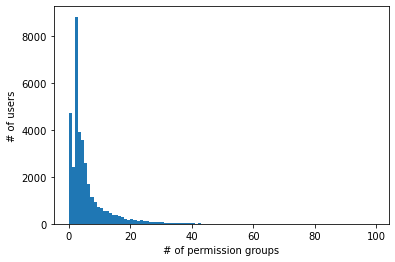

In [117]:
accesses_per_user = []
for i in range(am.shape[0]):
    accesses_per_user.append(np.count_nonzero(am[i]))
plt.hist(accesses_per_user,bins=list(range(0,100,1)))
plt.xlabel('# of permission groups')
plt.ylabel('# of users')

In [6]:
counts = Counter(accesses_per_user)
print(dict(sorted(counts.items())))

{0: 4735, 1: 2432, 2: 8830, 3: 3913, 4: 3579, 5: 2581, 6: 1703, 7: 1160, 8: 916, 9: 737, 10: 661, 11: 531, 12: 534, 13: 450, 14: 391, 15: 383, 16: 316, 17: 273, 18: 220, 19: 180, 20: 201, 21: 152, 22: 136, 23: 149, 24: 117, 25: 106, 26: 92, 27: 79, 28: 68, 29: 61, 30: 68, 31: 40, 32: 40, 33: 37, 34: 16, 35: 25, 36: 18, 37: 20, 38: 13, 39: 14, 40: 14, 41: 11, 42: 14, 43: 5, 44: 5, 45: 4, 46: 4, 47: 2, 48: 3, 49: 3, 50: 1, 51: 4, 53: 2, 54: 1, 56: 2, 57: 2, 58: 4, 65: 1, 67: 1, 71: 1, 87: 1, 99: 1}


The analysis, made above, shows, that there are a lot of users (4735) in the dataset, that do not have any access rights. They can be clearly defined as outliers for our unsupervised learning approach. As our intended algorithm is based on the similarity between users access rights and/ or the membership of different users in permission groups, this would clearly not work well for users without access rights. As a result we will strip the dataset from all rows containing only zeros. This is also sensible in the context of a possible usecase for our algorithm, as it does not seem wise to automatically grant a user access, that was not primarily known to the system before and does not have any access rights. In my opinion, the same argument is true for users with a very small amount of access rights. Here our algorithm would also perform poorly, because for the example of a user with only one permission group there could be 9116 different groups to choose and we have only around 2400 users with a single group. There is no chance that an algorithm based on similarity can possibly differentitate between the single groups. As a result, we will focus our work on users with more or equal to ten permission groups.

The upper boundary for our analysis regarding the amount of permission groups can also be analyzed using the above plots. As their are only very few users having more than 30 permission groups our algorithm would have a hard time to find similar users for users like that. For this reason we will concentrate our further work on users with a maximum of 30 permission groups.

Text(0, 0.5, '# of users')

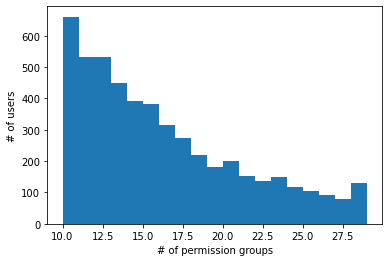

In [118]:
plt.hist(accesses_per_user,bins=list(range(10,30,1)))
plt.xlabel('# of permission groups')
plt.ylabel('# of users')

As a result the distribution of the number of permission groups per user in our cleaned dataset is a lot more homogenious and therefore more appropriate as an input for our algorithm.

The same argumentation is true for permission groups with none or only a small amount of users, as well as permission groups with a huge amount of users, which is why we also limited them to a range of 10 to 62 users per group.





{0: 3069, 1: 760, 2: 623, 3: 522, 4: 371, 5: 359, 6: 325, 7: 311, 8: 266, 9: 226, 10: 187, 11: 175, 12: 124, 13: 128, 14: 111, 15: 89, 16: 60, 17: 83, 18: 54, 19: 64, 20: 52, 21: 38, 22: 45, 23: 36, 24: 36, 25: 44, 26: 23, 27: 30, 28: 21, 29: 25, 30: 31, 31: 19, 32: 29, 33: 28, 34: 16, 35: 21, 36: 11, 37: 13, 38: 18, 39: 17, 40: 15, 41: 11, 42: 12, 43: 12, 44: 9, 45: 19, 46: 10, 47: 15, 48: 12, 49: 7, 50: 19, 51: 8, 52: 10, 53: 13, 54: 8, 55: 6, 56: 10, 57: 7, 58: 7, 59: 13, 60: 6, 61: 5, 62: 5, 63: 8, 64: 8, 65: 7, 66: 5, 67: 6, 68: 4, 69: 7, 70: 5, 71: 4, 72: 5, 73: 7, 74: 3, 76: 4, 77: 4, 78: 4, 79: 1, 80: 6, 81: 6, 82: 5, 83: 2, 84: 2, 85: 7, 86: 2, 87: 4, 88: 6, 89: 3, 90: 5, 91: 4, 92: 5, 93: 1, 94: 1, 95: 4, 96: 3, 97: 2, 98: 5, 99: 4, 100: 3, 101: 2, 102: 1, 103: 1, 104: 4, 105: 4, 106: 1, 107: 4, 108: 2, 109: 3, 110: 1, 111: 1, 112: 1, 113: 1, 114: 4, 115: 1, 116: 2, 117: 5, 118: 2, 120: 3, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 3, 127: 1, 128: 1, 130: 2, 131: 1, 132: 3,

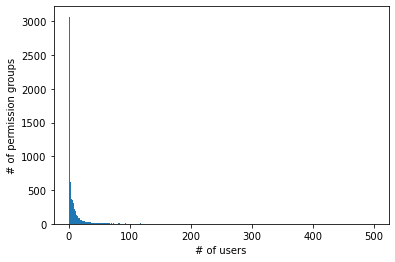

In [126]:
user_per_group = []
for i in range(am.shape[1]):
    user_per_group.append(np.count_nonzero(am[:,i]))
plt.hist(user_per_group,bins=list(range(0,500,1)))
plt.xlabel('# of users')
plt.ylabel('# of permission groups')

counts = Counter(user_per_group)
print(dict(sorted(counts.items())))

Text(0, 0.5, '# of permission groups')

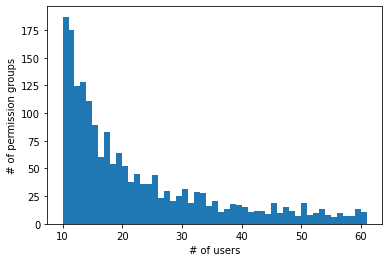

In [128]:
user_per_group = []
for i in range(am.shape[1]):
    user_per_group.append(np.count_nonzero(am[:,i]))
plt.hist(user_per_group,bins=list(range(10,62,1)))
plt.xlabel('# of users')
plt.ylabel('# of permission groups')

In summary our analysis is centered on the region between 10 and 30 permission groups and 10 and 62 users, which leaves enough space for possible uses cases of the algorithm and should substantially improve the algorithms performance. Due to these contraints, there will be a remaining dataset of 5166 users and 1525 permission groups.

Due to our operation, that removed specific users, the initial row and column indices were changed. We will create a mapping table for the transfer between the old and the new indices to make future analysis using additional data from the original dataset possible. Interesting data from the original dataset could for example be the user attributes, which have been used literature regarding this dataset. 

In [114]:
def indmap(old_array,axis,removed_ind):
    # Function mapping indices from old to new dataset
    out = dict() # dict with key old index and value new index
    k=0
    for i in range(old_array.shape[axis]):
        if k>=len(removed_ind):
            break
        elif i<removed_ind[k]:
            out[i]=i
        elif i == removed_ind[k]:
            out[i]=None
            k+=1
        else:
            out[i]=i-(k+1)
    return(out)

In [129]:
accesses_per_user = []
for i in range(am.shape[0]):
    accesses_per_user.append(np.count_nonzero(am[i]))

rem_ind = []
for i in range(len(accesses_per_user)):
    if accesses_per_user[i] < 10 or accesses_per_user[i] > 30:
        rem_ind.append(i)
ram = np.delete(am, rem_ind, axis=0)

map0a = indmap(am, 0,rem_ind)

###############

user_per_group = []
for i in range(ram.shape[1]):
    user_per_group.append(np.count_nonzero(ram[:,i]))

rem_ind_col = []
for i in range(len(user_per_group)):
    if user_per_group[i] < 10 or accesses_per_user[i] > 62:
        rem_ind_col.append(i)

map1a = indmap(ram,1,rem_ind_col)

ram = np.delete(ram, rem_ind_col, axis=1)



################ Final round, removing only new zeros, which appeared due to the cleaning steps before

accesses_per_user = []
for i in range(ram.shape[0]):
    accesses_per_user.append(np.count_nonzero(ram[i]))
rem_ind = []
for i in range(len(accesses_per_user)):
    if accesses_per_user[i] == 0:
        rem_ind.append(i)
                
map0b = indmap(ram,0,rem_ind)
        
ram = np.delete(ram, rem_ind, axis=0)

################

user_per_group = []
for i in range(ram.shape[1]):
    user_per_group.append(np.count_nonzero(ram[:,i]))
rem_ind_col = []
for i in range(len(user_per_group)):
    if user_per_group[i] == 0:
        rem_ind_col.append(i)
        
map1b = indmap(ram,1,rem_ind_col)
        
ram = np.delete(ram, rem_ind_col, axis=1)
print(ram.shape)

(5166, 1525)


## Correlation Analysis

Before doing the train-test split, we will inspect the data in more detail. First of all, we will have a look at the distribution of zeros and ones or access and no access in our data. When doing that, we see, that each user has only access to about 0,3% of all permission groups. We have to keep that in mind, when building our model on user-user similarity metrics, as this consitutes a highly unbalanced dataset. So predicting always zero would lead to a nearly perfect accuracy, while being obviously not the optimal solution. The same is true for item-item similarity, which in detail means, that only about 3,2% of users have access to a specific permission group. So the data is also highly unbalanced in this dimension.

In [130]:
c = []
d = []
for i in range(ram.shape[0]):
    c.append(np.count_nonzero(ram[i])-np.count_nonzero(np.isnan(ram[i])))
print(np.mean(c)/(0.9*ram.shape[0]))
for i in range(ram.shape[1]):
    d.append(np.count_nonzero(ram[:,i])-np.count_nonzero(np.isnan(ram[:,i])))
print(np.mean(d)/(0.9*ram.shape[1]))

0.00282849263362878
0.0324581802980083


It is not sensible for a dataset with as many features as ours to plot a correlation matrix. However, we comput the correlation matrix between users, based on the Pearson Correlation Coefficient for the whole dataset. The output shows the combination of indices with a correlation coefficient of "1". This means, that there are 316 combinations of users with the exact same permission groups. This makes sense in an organizational sense for the company and should help our algorithm in performing well. The same is true for the other dimension of the data, which means in detail, that there are 104 combinations of groups, which contain the exact same users (correlation of 1).

In [136]:
user_user_cor = np.corrcoef(ram)
print(user_user_cor)
np.fill_diagonal(user_user_cor, 0)
print(len(list(zip(*np.where(user_user_cor == user_user_cor.max())))))

[[ 1.         -0.00820475 -0.00653649 ... -0.00857241 -0.00959376
  -0.0105199 ]
 [-0.00820475  1.         -0.00578824 ... -0.0075911  -0.00849553
  -0.00931565]
 [-0.00653649 -0.00578824  1.         ... -0.00604762 -0.00676815
  -0.00742152]
 ...
 [-0.00857241 -0.0075911  -0.00604762 ...  1.          0.29192919
   0.19641918]
 [-0.00959376 -0.00849553 -0.00676815 ...  0.29192919  1.
   0.11215479]
 [-0.0105199  -0.00931565 -0.00742152 ...  0.19641918  0.11215479
   1.        ]]
316


In [137]:
item_item_cor = np.corrcoef(ram,rowvar=False)
print(item_item_cor)
np.fill_diagonal(item_item_cor, 0)
print(len(list(zip(*np.where(item_item_cor == item_item_cor.max())))))

[[ 1.         -0.00844639 -0.00486421 ... -0.00426495 -0.00467293
   0.40884884]
 [-0.00844639  1.         -0.00438069 ... -0.003841   -0.00420842
  -0.003841  ]
 [-0.00486421 -0.00438069  1.         ... -0.002212   -0.00242359
  -0.002212  ]
 ...
 [-0.00426495 -0.003841   -0.002212   ...  1.         -0.00212501
  -0.00193949]
 [-0.00467293 -0.00420842 -0.00242359 ... -0.00212501  1.
  -0.00212501]
 [ 0.40884884 -0.003841   -0.002212   ... -0.00193949 -0.00212501
   1.        ]]
104


## Train/ Test Split and Transformation

In the following, we will perform a train-test split on the data by removing the access information for a random combination of user and permission group. These access information will be stored separately from the training data. We will use a data format, that is similar to the one, used in the week three movie rating recommender system. This will allow us to use an adapted version of its recommender system class. As we have to differentiate in our sparse access matrix between no access and no data, we will have to transform the no access values to "-1". Other transformations are not necessary, as we are working on binary input data.

In [15]:
uid = []
aid = []
a_val = []

for i in range(ram.shape[0]):
    for j in range(ram.shape[1]):
        uid.append(i)
        aid.append(j)
        a_val.append(ram[i,j])
total = np.array([uid,aid,a_val]).T
total = pd.DataFrame(total,columns=('uid','aid','status'))
total['status'] = total['status'].map({0: int(-1), 1: 1})

train, test = train_test_split(total, test_size=0.1, random_state=42)

train.head()

,uid,aid,status
6988262,4582,712,-1
5071494,3325,869,-1
7234520,4743,1445,-1
5535510,3629,1285,-1
1851870,1214,520,-1


As a final step of our EDA procedure we produced our train and test datasets, later used in model building and training or analysis respectively.

# Model Building

## Recommender System

In the following we will use an adapted form of the recommender system class from the week three assignment of this course. First we had to change the context and used dimension of the algorithm, which also implied slight changes in the matrix multiplication steps. However, must of the algorithm is still based on the content, outlined in week three. Furthermore, we have added a method to get the confusion matrix for our models, as a way to assess its performance.

In [146]:
from sklearn.metrics import pairwise_distances

class RecSys():
    def __init__(self,ram,train,test):
        self.train = train
        self.test = test
        self.allusers = list(range(ram.shape[0]))
        self.allaccess = list(range(ram.shape[1]))
        self.Mr=self.rating_matrix()
        self.sim=np.zeros((len(self.allaccess),len(self.allaccess)))
        
        
    def rating_matrix(self):
        """
        Convert the rating matrix to numpy array of shape (#allusers,#allmovies)
        """
        ind_access = [x for x in self.train.aid] 
        ind_user = [x for x in self.train.uid]
        access_train = self.train.status
        
        return np.array(coo_matrix((access_train, (ind_user, ind_access)), shape=(len(self.allusers), len(self.allaccess))).toarray())


    def predict_everything_to_0(self):
        """
        Predict everything to 0 for the test data
        """
        return(np.array([0]*len(self.test)))
        
    def predict_everything_to_1(self):
        """
        Predict everything to 1 for the test data
        """
        return(np.array([1]*len(self.test))) 
       
    def predict_to_group_average(self):
        """
        Predict to average rating for the user.
        Returns numpy array of shape (#groups,)
        """
        # Generate an array as follows:
        # 1. Calculate all avg access as sum of accesses of group across all users with access != 0
        # 2. Return the average access of groups in test data
        # your code here
         
        # self.Mr!=0 idea copied from: https://stackoverflow.com/questions/38542548/numpy-mean-of-nonzero-values
        means = self.Mr.sum(axis=0)/(self.Mr!=0).sum(axis=0)
        out = [means[x] for x in list(self.test['aid'])]
        return(np.array(out))  
    
    def predict_from_sim(self,uid,aid):
        """
        Predict a user rating on a movie given userID and movieID
        """
        # Predict user rating as follows:
        # 1. Get entry of user id in rating matrix
        # 2. Get entry of movie id in sim matrix
        # 3. Employ 1 and 2 to predict user rating of the movie
        # your code here
        return(np.dot(self.Mr[:,aid],self.sim[uid])/np.dot(self.sim[uid],self.Mr[:,aid]!=0))
        pass
    
    def predict(self):
        """
        Predict ratings in the test data. Returns predicted rating in a numpy array of size (# of rows in testdata,)
        """
        # your code here
        out = []
        for a,b in zip(list(self.test['uid']),list(self.test['aid'])):
            out.append(self.predict_from_sim(a,b))
        return(np.array(out))
        pass
    
    def rmse(self,yp):
        yt=np.array(self.test.status)
        return np.sqrt(((yt-yp)**2).mean())
    
    def conf_matr(self,yp):
        yt=np.array(self.test.status)
        fp=0
        tp=0
        fn=0
        tn=0
        for p,t in zip(yp,yt):
            if p<0:
                p=-1
            else:
                p=1
            
            if p==1 and p!=t:
                fp+=1
            elif p==1 and p==t:
                tp+=1
            elif p==-1 and p!=t:
                fn+=1
            elif p==-1 and p==t:
                tn+=1
        return('False positives: ',fp, 'True positives: ',tp,'False negatives: ',fn,'True negatives: ',tn,)
                
class Collaborative(RecSys):    
    def __init__(self,ram,train,test):
        super().__init__(ram,train,test)
        
    def calc_item_item_similarity(self, simfunction, *X):  
        """
        Create item-item similarity using similarity function. 
        X is an optional transformed matrix of Mr
        """    
        # General function that calculates item-item similarity based on the sim function and data inputed
        if len(X)==0:
            self.sim = simfunction()            
        else:
            self.sim = simfunction(X[0]) # *X passes in a tuple format of (X,), to X[0] will be the actual transformed matrix
            
    def cossim(self):    
        """
        Calculates item-item similarity for all pairs of items using cosine similarity (values from 0 to 1) on utility matrix
        Returns a cosine similarity matrix of size (#all movies, #all movies)
        """
        # Return a sim matrix by calculating item-item similarity for all pairs of items using Jaccard similarity
        # Cosine Similarity: C(A, B) = (A.B) / (||A||.||B||) 
        # your code here
        
        #Code according to resources tab
        
        access_allUsers = self.Mr.sum(axis=1)/(self.Mr!=0).sum(axis=1)
                        
        acc_avg = self.Mr/np.repeat(np.expand_dims(np.sqrt((self.Mr**2).sum(axis=1)),axis=1),self.Mr.shape[1],axis=1)
                
        acc_avg[np.isnan(acc_avg)] = 0
                
        cos = np.dot(acc_avg, acc_avg.T) # We have already divided by the L2-Norm before, so division is not necessary here
                
        for i in range(len(self.allusers)):
                cos[i, i] = 1
                
        return(0.5+0.5*cos)
    
    def jacsim(self,Xr):
        """
        Calculates item-item similarity for all pairs of items using jaccard similarity (values from 0 to 1)
        Xr is the transformed rating matrix.
        """    
        # Return a sim matrix by calculating item-item similarity for all pairs of items using Jaccard similarity
        # Jaccard Similarity: J(A, B) = |A∩B| / |A∪B| 
        # your code here
        
        # code adapted from resources tab
        
        n = Xr.shape[0]
        maxr = int(Xr.max())
        #if maxr>=1:
        intersection = np.zeros((n,n)).astype(int)
        for i in range(-1, maxr+1):
            csr = csr_matrix((Xr==i).astype(int))
            intersection = intersection + np.array(csr.dot(csr.T).toarray()).astype(int)    
        
        #Convert Xr into a CSR format
        csr0 = csr_matrix((Xr!=0).astype(int))
        
        #Take the dot product
        nz_inter = np.array(csr0.dot(csr0.T).toarray()).astype(int)   
        
        # Formula JS:
        A = (Xr!=0).astype(bool)
        rowsum = A.sum(axis=1)
        rsumtile = np.repeat(rowsum.reshape((n,1)),n,axis=1)   
        union = rsumtile.T + rsumtile - nz_inter
        
        out = intersection / union
        
        out[np.isnan(out)] = 0
        for i in range(len(self.allusers)):
                out[i, i] = 1
        # Perform the two boundary checks:-
        #  - since dividing by magnitude may produce inf, zeros, etc. Set nans to 0.
        #  - Covariance/correlation values for np.dot([M.T, M]) matrix should have 
        #    diagonal set to 1.
        return(out)
    
    

In [147]:
cf = Collaborative(ram,train,test)
Xr = cf.Mr.astype(int)
t0=time.perf_counter()
cf.calc_item_item_similarity(cf.cossim)#,Xr)
t1=time.perf_counter()
time_sim = t1-t0
print('similarity calculation time',time_sim)
yp = cf.predict()
print(yp)
print(cf.conf_matr(yp))

similarity calculation time 0.5967128299998876
[-0.99657387 -0.99311475 -0.98507362 ... -0.97273642 -0.99144516
 -0.99657724]
('False positives: ', 0, 'True positives: ', 0, 'False negatives: ', 6900, 'True negatives: ', 780915)


In [150]:
print(max(yp))
print(cf.sim)
print(cf.sim.shape)

-0.2185679502587226
[[1.         0.94124492 0.93165308 ... 0.93909368 0.93200183 0.93225557]
 [0.94124492 1.         0.9425761  ... 0.94264793 0.93960254 0.94161049]
 [0.93165308 0.9425761  1.         ... 0.9371506  0.93367911 0.93393078]
 ...
 [0.93909368 0.94264793 0.9371506  ... 1.         0.94287965 0.93912115]
 [0.93200183 0.93960254 0.93367911 ... 0.94287965 1.         0.93750286]
 [0.93225557 0.94161049 0.93393078 ... 0.93912115 0.93750286 1.        ]]
(5166, 5166)


We can clearly see from the results, that the recommender system, based on collaborative filtering, is always predicting zero or no-access, because of the strong inbalance in the dataset, that yields to constantly high similiarity values (compare output above). This is obviously not a great result, as no machine learning model is necesssary to come to that conclusion. However, it strongly illustrates the negative aspects of classical collaborative filtering. It is not able to deal with unbalanced data. We could shift the decision boundary between access and no access more into the region of no access to alter the result, as the maximum predicted value is currently -0.21. However, this approach would not be universally valid for different dataset. Instead we will next test the method using jaccard distance instead of cosine similiarity to confirm, that this does not change the results and then move on to another unsupervised approach, that will hopefully yield more useful results. We do not do any hyperparamter optimization in this step, as both cosine and jaccard similiarity do not have such parameters.

In [151]:
cf2 = Collaborative(ram,train,test)
Xr = cf2.Mr.astype(int)
t0=time.perf_counter()
cf2.calc_item_item_similarity(cf2.jacsim,Xr)
t1=time.perf_counter()
time_sim = t1-t0
print('similarity calculation time',time_sim)
yp = cf2.predict()
print(yp)
print(cf2.conf_matr(yp))
print(cf2.sim)

similarity calculation time 109.29025256499881
[-0.99657539 -0.9931064  -0.98510407 ... -0.97274589 -0.99142826
 -0.99657988]
('False positives: ', 0, 'True positives: ', 0, 'False negatives: ', 6900, 'True negatives: ', 780915)
[[1.         0.82792852 0.79933993 ... 0.82571239 0.80474934 0.81427627]
 [0.82792852 1.         0.83090186 ... 0.8322325  0.8287037  0.83531746]
 [0.79933993 0.83090186 1.         ... 0.81800132 0.80343008 0.8129544 ]
 ...
 [0.82571239 0.8322325  0.81800132 ... 1.         0.83300199 0.82201714]
 [0.80474934 0.8287037  0.80343008 ... 0.83300199 1.         0.82594308]
 [0.81427627 0.83531746 0.8129544  ... 0.82201714 0.82594308 1.        ]]


We see, that using jaccard similiarity as a metric yields the same results. So, the lesson learned from this part of the project is, that recommender systems in the classical sense are not suitable for highly unbalanced data. In case of of a multi-class classification problem we could have maybe removed the most frequent and therefore obvious class to receive a valid recommender system. However, removing a class in a binary classification problem is not an option. As stated before we will move on and try to check the suitability of unsupervised assocation rule mining on our dataset.

## Unsupervised Frequent Itemset Analysis with Apriori - Algorithm

Again the algorithm, used below, is adapted from the courses of the MSDS program. DTSA5505 gives a good overview of assocation rule learning and we will use the algorithm from this class as a starting point for our analysis. We had to adapt the algorithm in terms of its input data, as the original was only working for string type input. Furthermore, we used the ideas from [3] as an input to our analysis, as the workings of the Apriori Algorithm are clearly described there as well.

In [69]:
# Algorithm adapted from DTSA5505 Week 1

def findsubsets(s, n):
    
#   A helper function that you can use to list of all subsets of size n. Do not make any changes to this code block.
#   Input: 
#       1. s - A python list of items
#       2. n - Size of each subset
#   Output:
#       1. subsets - A python list containing the subsets of size n.
    
    subsets = list(sorted((itertools.combinations(s,n))))
    return subsets

def items_from_frequent_itemsets(frequent_itemset):

#   A helper function that you can use to get the sorted items from the frequent itemsets. Do not make any changes
#   to this code block
#   Input:
#       1. Frequent Itemsets
#   Output:
#       1. Sorted list of items

    items = list()
    for keys in frequent_itemset.keys():
        try:
            for item in list(keys):
                items.append(item)
        except:
            items.append(keys)
    return sorted(list(set(items)))

def generate_frequent_itemsets(dataset, support, items, n=1, frequent_items={}):
    
#   Input:
#       1. dataset - A python dictionary containing the transactions.
#       2. support - A floating point variable representing the min_support value for the set of transactions.
#       3. items - A python list representing all the items that are part of all the transactions.
#       4. n - An integer variable representing what frequent item pairs to generate.
#       5. frequent_items - A dictionary representing k-1 frequent sets. 
#   Output:
#       1. frequent_itemsets - A dictionary representing the frequent itemsets and their corresponding support counts.
    
    len_transactions = len(dataset)
    if n == 1:
        frequent_items = {}
        for item in items:
            count = 0
            for key, value in dataset.items():
                if item in value:
                    count += 1
            if count >= len_transactions * support:
                frequent_items[(item)] = count
        return(frequent_items)
    
    else:
        it = items_from_frequent_itemsets(frequent_items)
        subsets = findsubsets(it,n)
        
        frequent_items = {}
        for subset in subsets:
            count = 0
            for key, value in dataset.items():
                if all(i in value for i in subset):
                    count += 1
            if count >= len_transactions * support:
                frequent_items[subset] = count
        return(frequent_items)

To use the algorithm we first have to generate the items as an input for our market basket analysis with the Apriori algorithm. To this end, we will build a dictionary containing the IDs of all the permission groups for each user, as a key-value pair.

In [70]:
dataset = dict()
for i in range(ram.shape[0]):
    dataset[i] = list(np.where(ram[i] == 1)[0])
items= list(range(ram.shape[1]))

We have said above, that, according to our analysis on average a user has only access to 0,3% of the 1525 analysed permission groups, which equals a permission group count of about 5, so we will first have a look whether there are frequent 5 itemsets. Furthermore we will use a support of 0.03, which means that a frequent itemset (permission group combination) must be present in 3% of users to be considered by the algorithm. This is our chosen support value because we learned above that a permission group contains 3% of all users on average.

In [152]:
f1s = generate_frequent_itemsets(dataset, 0.03, items, n=1)
f2s = generate_frequent_itemsets(dataset, 0.03, items, 2, f1s)
f3s = generate_frequent_itemsets(dataset, 0.03, items, 3, f2s)
f4s = generate_frequent_itemsets(dataset, 0.03, items, 4, f3s)
f5s = generate_frequent_itemsets(dataset, 0.03, items, 5, f4s)
print(f5s)
f6s = generate_frequent_itemsets(dataset, 0.03, items, 6, f5s)
print(f6s)

{(427, 830, 1102, 1159, 1268): 182, (427, 855, 1102, 1159, 1268): 159, (427, 904, 1102, 1159, 1268): 181, (805, 814, 1102, 1159, 1268): 160, (830, 904, 1102, 1159, 1268): 162, (855, 899, 1102, 1159, 1268): 172, (855, 904, 1102, 1159, 1268): 167, (855, 913, 1102, 1159, 1268): 171}
{}


In fact our analysis shows, that frequent 5 itemsets are the maximal frequent itemsets, because there are no bigger itemsets with the same support. Based on the ideas, above this is no big surprise and confirms our idea of using the average numbers of users per group and accesses per user as a starting point for our size of the itemset and our target support.

With respect to the results our advice for anyone, maintaining access rights, would be to at least check the above printed frequent 5 itemsets with their support for combinations, that could be directly used for new users in the system, depending on their exact role.

So, in contrast to the recommender system the assocation rule mining yields valuable results for our dataset. These results could be further expanded by answering specific questions about the dataset like: "What is the probability of a user having the permission group c if he or she already has a and b?". We will not answer these kinds of questions in this work, as there are obviously millions of possibilites. However, with the output of our Apriori Algorithm as a basis these kinds of questions could be easily answered in production as needed (see [3]).

Finally we will do some hyperparameter variation for our Apriori Algorithm to see whether the effect of a change in support matches the intuition. We will only consider frequent 1 itemsets. As the algorithm is quite intense in computing time and varying the support for larger itemsets would therefore last way to long.

Text(0, 0.5, 'frequent 1 itemsets')

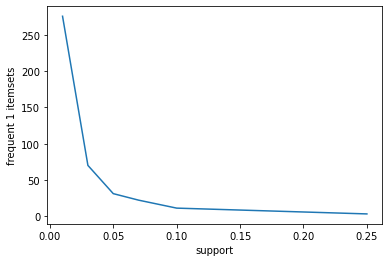

In [156]:
fs = []
testparams = [0.01, 0.03, 0.05, 0.07, 0.1, 0.25]
for i in testparams:
    fs.append(len(list(generate_frequent_itemsets(dataset, i, items, n=1).keys())))

plt.plot(testparams, fs)
plt.xlabel('support')
plt.ylabel('frequent 1 itemsets')

As the plot shows, the results match the intuition. The number of frequent itemsets reduces with increasing support. And there are nearly no frequent 1 itemsets with a support greater than 10% in our dataset. Which means, that nearly no permission group has more than 10% of users as members.

# Results, Discussion and Conclusion

In summary, this work shows, that recommender systems, based on collaborative filtering are not suitable for highly unbalanced datasets in a binary classification problem. Furthermore, we observed that assocation rules are a powerful tool to acquire insights (frequent itemsets) even from this kind of highly distorted data. 

In a future work I would possibly choose a smaller dataset, as the size of this dataset made every step of the analysis complex. Reading the data, was complex as pandas was consuming way to much memory for this task and reducing the data to a sensible subgroup of the whole dataset, without being able to plot the single features, as there were that many, was also a bit of a challenge.

Nevertheless the task was interesting and I learned a lot about handling "big data".

## References

[1] Montanez,Ken. (2011). Amazon Access Samples. UCI Machine Learning Repository. https://doi.org/10.24432/C5JW2K.

[2] Montanez et. al. (2012), THE EIGHTH ANNUAL MLSP COMPETITION: OVERVIEW

[3| Association Rules (xxxx), https://www.ipd.kit.edu/~ipd/institut/dwm2004-05/dwm-kap11-4auf1.pdf

[4] Ricci et. al. (2011), Recommender System Handbook

[5] Liu et. al (2015), Similarity Learning for High-Dimensional Sparse Data

## Documentation of Packages

In [157]:
conda list

# packages in environment at /opt/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
alabaster                 0.7.12             pyhd3eb1b0_0  
altair                    4.2.2              pyhd8ed1ab_0    conda-forge
anaconda                  2021.05                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        2.3.2            py38hecd8cb5_0  
anaconda-project          0.9.1              pyhd3eb1b0_1  
anyio                     2.2.0            py38hecd8cb5_1  
appdirs                   1.4.4                      py_0  
applaunchservices         0.2.1                      py_0  
appnope                   0.1.2           py38hecd8cb5_1001  
appscript                 1.1.2            py38h9ed2024_0  
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38h9ed2024_1  
asn1crypto                1.4.0


Note: you may need to restart the kernel to use updated packages.
